In [407]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
 - Remove participant if more than 10% of the data is removed (?) 
    

### Pilot Analysis Plots

1. Overall Accuracy
    - accuracy by scene category
    - accuracy by zoom 
    - accuracy by zoom x match
2. RT Distribution
    - RT by scene category
    - RT by zoom 
    - RT by zoom x match
3. 2x3 ANOVA
 

In [408]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [409]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [410]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  165


In [411]:
# input_data

In [412]:
num_trials = 16

In [413]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    prac_too_many_dist = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            prac_too_many_dist.append(subj_num_practice_tries)
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2, prac_too_many_dist
    

In [414]:
pracTries_cleaned_data, prac_dist = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 44


In [415]:
x = [d for d in prac_dist if d > 5]

len(x), len(prac_dist)

(22, 44)

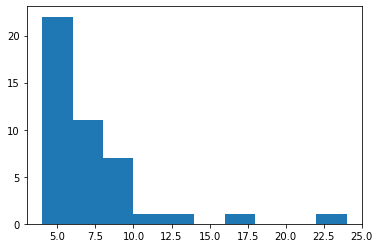

In [416]:
plt.hist(prac_dist)
plt.show()

In [417]:
len(pracTries_cleaned_data.subjID.unique())

121

In [418]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        
        acc_column = np.array(list(subj_df['accuracy']))
        sum_acc = np.sum(acc_column)
        
        
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
        
        subj_acc = sum_acc/num_trials
#         print(acc_column)
#         print(subj, sum_acc, subj_acc)
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
#             print(subj_acc, subj)
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
            
#         else:
#             print(subj_acc)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [419]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(pracTries_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  58
Number of participants that did not respond for 4 or more trials: 0
Number of participants left:  63


In [420]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [421]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(Accuracy_cleaned_data, [250, 2000], num_trials)


63
62


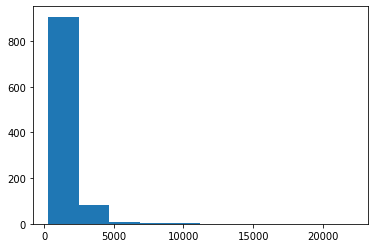

In [422]:
plt.hist(trialRTs_distribution)
plt.show()

In [423]:
all_subjIDs = RT_cleaned_data.subjID.unique()
dist = []
for subj in all_subjIDs:
    count = 0
    subj_df = RT_cleaned_data.loc[RT_cleaned_data['subjID'] == subj]
    dist.append(len(subj_df))
#     print(len(subj_df))

In [424]:
len([d for d in dist if d >11])

46

In [425]:
# pracTries_cleaned_data.subjID.unique(), RT_cleaned_data.subjID.unique()

In [426]:
def finalTrialCountCheck(df, num_trials, min_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        if count_trials < min_trials:
            remove.append(subj)
            
#         threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

#         if count_trials <= threshold_trials_remaining:
#             remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [427]:
finalTrialCount_data = finalTrialCountCheck(RT_cleaned_data, num_trials, 12)

Number of Participants with >= 10% trials removed:  16
Number of participants left:  46


In [428]:
raw_final_data = finalTrialCount_data.copy(deep=True)
len(raw_final_data.subjID.unique())

46

In [429]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score RT
        average_RT = subj_df["RT"].mean()
        std_RT = subj_df["RT"].std()
        subj_RTs = np.array(list(subj_df["RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.insert(4, 'Z-Scored RT',zscored_subj_RTs)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2

In [430]:
zs_final_data = zscored_outcomes(raw_final_data)

In [443]:
def recode_ratings(df):
    '''
    4, 3+5, 2+6, 1+7
    labeled: 4, 3, 2, 1
    where 4 is scaled, and 1 is most mis-scaled
    '''
    
    df['rating'] = df['rating'].replace(5, 3)
    df['rating'] = df['rating'].replace(6, 2)
    df['rating'] = df['rating'].replace(7, 1) 

    return df

In [444]:
recoded_ratings_data = recode_ratings(zs_final_data)

In [445]:
recoded_ratings_data.rating.unique()

array([3, 1, 2, 4])

In [434]:
final_data = recoded_ratings_data.copy(deep=True)

In [435]:
def get_misscaled_trials(df):
    """
    args:
        df  
    returns:
        array of misscaled/scaled
    """
    misscaled_col = []
    
    for idx, row in df.iterrows():
        if row['scene1ZoomName'] == 'zo' and row['objectSize']=='small':
            misscaled_col.append('misscaled')

        if row['scene1ZoomName'] == 'zi' and row['objectSize']=='large':
            misscaled_col.append('misscaled')
            
        if row['scene1ZoomName'] == 'zo' and row['objectSize']=='large':
            misscaled_col.append('scaled')

        if row['scene1ZoomName'] == 'zi' and row['objectSize']=='small':
            misscaled_col.append('scaled')
            
            
            
    
    return np.array(misscaled_col)

In [436]:
misscaled_column = get_misscaled_trials(final_data)

# # add misscaled column to dataframe 
final_data.insert(14, "misscaled", misscaled_column)


In [338]:
final_data.to_csv('zs_e4v1_b3b4.csv', index=False)

In [437]:
len(final_data.subjID.unique())

46

## Accuracy


add error bars
- overall accuracy per subj in each condition 

In [373]:
# data split by object-scene size congruency aka scene zoom 

zo_df = final_data.loc[final_data['scene1ZoomName']=='zo']
zi_df = final_data.loc[final_data['scene1ZoomName']=='zi']

zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))

zo_acc, zi_acc

(0.8951841359773371, 0.889196675900277)

In [374]:
misscaled_zo = zo_df.loc[zo_df['misscaled'] =='misscaled'] 
misscaled_zi = zi_df.loc[zi_df['misscaled'] =='misscaled']
misscaled = misscaled_zo.append(misscaled_zi)

scaled_zo = zo_df.loc[zo_df['misscaled'] =='scaled'] 
scaled_zi = zi_df.loc[zi_df['misscaled'] =='scaled']
scaled = scaled_zo.append(scaled_zi)

misscaled_acc = np.sum(np.array(misscaled['accuracy']))/len(np.array(misscaled['accuracy']))
scaled_acc = np.sum(np.array(scaled['accuracy']))/len(np.array(scaled['accuracy']))

misscaled_acc, scaled_acc

(0.8845070422535212, 0.8997214484679665)

In [375]:
# object scene semantic congruency 
# var = objectScene1SemanticCongruency
# acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))

misscaled_zo_objSemCong = misscaled_zo.loc[misscaled_zo["objectScene1SemanticCongruency"]==1]
misscaled_zo_objSemIncong = misscaled_zo.loc[misscaled_zo["objectScene1SemanticCongruency"]==0]

misscaled_zo_objSemCong_acc = np.sum(np.array(misscaled_zo_objSemCong['accuracy']))/len(np.array(misscaled_zo_objSemCong['accuracy']))
misscaled_zo_objSemIncong_acc =np.sum(np.array(misscaled_zo_objSemIncong['accuracy']))/len(np.array(misscaled_zo_objSemIncong['accuracy']))

misscaled_zo_objSemCong_sem = np.std(np.array(misscaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemCong['accuracy'])))
misscaled_zo_objSemIncong_sem = np.std(np.array(misscaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zo_objSemIncong['accuracy'])))


misscaled_zi_objSemCong = misscaled_zi.loc[misscaled_zi["objectScene1SemanticCongruency"]==1]
misscaled_zi_objSemIncong = misscaled_zi.loc[misscaled_zi["objectScene1SemanticCongruency"]==0]

misscaled_zi_objSemCong_acc = np.sum(np.array(misscaled_zi_objSemCong['accuracy']))/len(np.array(misscaled_zi_objSemCong['accuracy']))
misscaled_zi_objSemIncong_acc = np.sum(np.array(misscaled_zi_objSemIncong['accuracy']))/len(np.array(misscaled_zi_objSemIncong['accuracy']))

misscaled_zi_objSemCong_sem = np.std(np.array(misscaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemCong['accuracy'])))
misscaled_zi_objSemIncong_sem = np.std(np.array(misscaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(misscaled_zi_objSemIncong['accuracy'])))

# scaled
scaled_zo_objSemCong = scaled_zo.loc[scaled_zo["objectScene1SemanticCongruency"]==1]
scaled_zo_objSemIncong = scaled_zo.loc[scaled_zo["objectScene1SemanticCongruency"]==0]

scaled_zo_objSemCong_acc = np.sum(np.array(scaled_zo_objSemCong['accuracy']))/len(np.array(scaled_zo_objSemCong['accuracy']))
scaled_zo_objSemIncong_acc =np.sum(np.array(scaled_zo_objSemIncong['accuracy']))/len(np.array(scaled_zo_objSemIncong['accuracy']))

scaled_zo_objSemCong_sem = np.std(np.array(scaled_zo_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemCong['accuracy'])))
scaled_zo_objSemIncong_sem = np.std(np.array(scaled_zo_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zo_objSemIncong['accuracy'])))


scaled_zi_objSemCong = scaled_zi.loc[scaled_zi["objectScene1SemanticCongruency"]==1]
scaled_zi_objSemIncong = scaled_zi.loc[scaled_zi["objectScene1SemanticCongruency"]==0]

scaled_zi_objSemCong_acc = np.sum(np.array(scaled_zi_objSemCong['accuracy']))/len(np.array(scaled_zi_objSemCong['accuracy']))
scaled_zi_objSemIncong_acc = np.sum(np.array(scaled_zi_objSemIncong['accuracy']))/len(np.array(scaled_zi_objSemIncong['accuracy']))

scaled_zi_objSemCong_sem = np.std(np.array(scaled_zi_objSemCong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemCong['accuracy'])))
scaled_zi_objSemIncong_sem = np.std(np.array(scaled_zi_objSemIncong['accuracy']))/np.sqrt(len(np.array(scaled_zi_objSemIncong['accuracy'])))

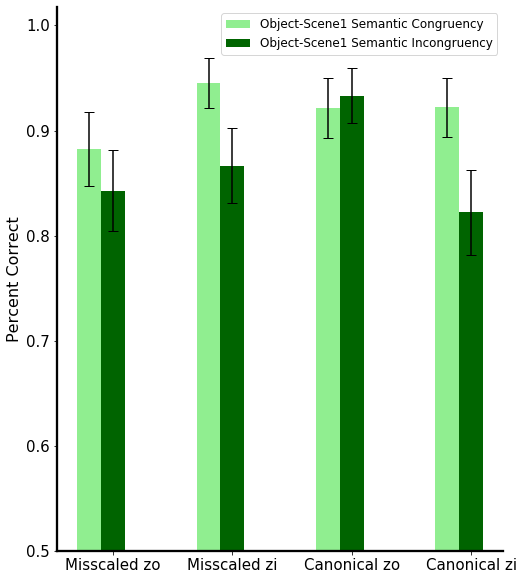

In [376]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
#                                          Misscaled                                               Scaled
#                                zo                          zi                         zo                       zi
Acc_objSemCong =   [misscaled_zo_objSemCong_acc, misscaled_zi_objSemCong_acc, scaled_zo_objSemCong_acc, scaled_zi_objSemCong_acc]
yerr_objSemCong =  [misscaled_zo_objSemCong_sem, misscaled_zi_objSemCong_sem, scaled_zo_objSemCong_sem, scaled_zi_objSemCong_sem]

Acc_objSemIncong =   [misscaled_zo_objSemIncong_acc, misscaled_zi_objSemIncong_acc, scaled_zo_objSemIncong_acc, scaled_zi_objSemIncong_acc]
yerr_objSemIncong =  [misscaled_zo_objSemIncong_sem, misscaled_zi_objSemIncong_sem, scaled_zo_objSemIncong_sem, scaled_zi_objSemIncong_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_objSemCong, width, color='lightgreen', label='Object-Scene1 Semantic Congruency', yerr=yerr_objSemCong, capsize=5)
plt.bar(x, Acc_objSemIncong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency', yerr=yerr_objSemIncong, capsize=5)
plt.xticks(x, ['Misscaled zo', 'Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')
plt.ylim(0.50)
plt.yticks(fontsize=15) 
plt.ylabel("Percent Correct", fontsize=16)
plt.legend(loc=1, fontsize=12)
plt.show()

## RT

CREATE DIFF DF - ONLY INCLUDE CORRECT TRIALS

WITHIN PARTICIPANT SEM

In [377]:
final_data_correctOnly = final_data.loc[final_data['accuracy']==1]

np.mean(np.array(final_data_correctOnly['RT']))

1170.6703296703297

In [378]:
# data split by object-scene size congruency aka scene zoom 

zo_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scene1ZoomName']=='zo']
zi_df_CO = final_data_correctOnly.loc[final_data_correctOnly['scene1ZoomName']=='zi']

zo_RT = np.mean(np.array(zo_df_CO['RT']))
zi_RT = np.mean(np.array(zi_df_CO['RT']))


zo_RT, zi_RT

(1145.737341772152, 1195.214953271028)

In [379]:
misscaled_zo_CO = zo_df_CO.loc[zo_df_CO['misscaled'] =='misscaled'] 
misscaled_zi_CO = zi_df_CO.loc[zi_df_CO['misscaled'] =='misscaled']
misscaled_CO = misscaled_zo_CO.append(misscaled_zi_CO)

scaled_zo_CO = zo_df_CO.loc[zo_df_CO['misscaled'] =='scaled'] 
scaled_zi_CO = zi_df_CO.loc[zi_df_CO['misscaled'] =='scaled']
scaled_CO = scaled_zo_CO.append(scaled_zi_CO)

In [380]:
misscaled_zo_objSemCong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objectScene1SemanticCongruency"]==1]
misscaled_zo_objSemIncong_CO = misscaled_zo_CO.loc[misscaled_zo_CO["objectScene1SemanticCongruency"]==0]

misscaled_zo_objSemCong_RT = np.mean(np.array(misscaled_zo_objSemCong_CO['RT']))
misscaled_zo_objSemIncong_RT = np.mean(np.array(misscaled_zo_objSemIncong_CO['RT']))

misscaled_zo_objSemCong_RT_sem = sem(np.array(misscaled_zo_objSemCong_CO['RT']))
misscaled_zo_objSemIncong_RT_sem = sem(np.array(misscaled_zo_objSemIncong_CO['RT']))


misscaled_zi_objSemCong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objectScene1SemanticCongruency"]==1]
misscaled_zi_objSemIncong_CO = misscaled_zi_CO.loc[misscaled_zi_CO["objectScene1SemanticCongruency"]==0]

misscaled_zi_objSemCong_RT = np.mean(np.array(misscaled_zi_objSemCong_CO['RT']))
misscaled_zi_objSemIncong_RT = np.mean(np.array(misscaled_zi_objSemIncong_CO['RT']))

misscaled_zi_objSemCong_RT_sem = sem(np.array(misscaled_zi_objSemCong_CO['RT']))
misscaled_zi_objSemIncong_RT_sem = sem(np.array(misscaled_zi_objSemIncong_CO['RT']))


# scaled
scaled_zo_objSemCong_CO = scaled_zo_CO.loc[scaled_zo_CO["objectScene1SemanticCongruency"]==1]
scaled_zo_objSemIncong_CO = scaled_zo_CO.loc[scaled_zo_CO["objectScene1SemanticCongruency"]==0]

scaled_zo_objSemCong_RT = np.mean(np.array(scaled_zo_objSemCong_CO['RT']))
scaled_zo_objSemIncong_RT = np.mean(np.array(scaled_zo_objSemIncong_CO['RT']))

scaled_zo_objSemCong_RT_sem = sem(np.array(scaled_zo_objSemCong_CO['RT']))
scaled_zo_objSemIncong_RT_sem = sem(np.array(scaled_zo_objSemIncong_CO['RT']))


scaled_zi_objSemCong_CO = scaled_zi_CO.loc[scaled_zi_CO["objectScene1SemanticCongruency"]==1]
scaled_zi_objSemIncong_CO = scaled_zi_CO.loc[scaled_zi_CO["objectScene1SemanticCongruency"]==0]

scaled_zi_objSemCong_RT = np.mean(np.array(scaled_zi_objSemCong_CO['RT']))
scaled_zi_objSemIncong_RT = np.mean(np.array(scaled_zi_objSemIncong_CO['RT']))

scaled_zi_objSemCong_RT_sem = sem(np.array(scaled_zi_objSemCong_CO['RT']))
scaled_zi_objSemIncong_RT_sem = sem(np.array(scaled_zi_objSemIncong_CO['RT']))


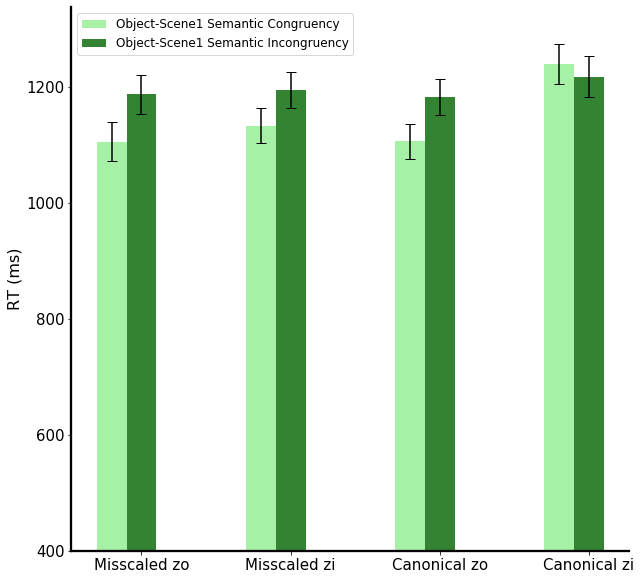

In [381]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)
#                                          Misscaled                                             Scaled
#                               zo                          zi                         zo                     zi
RT_objSemCong =   [misscaled_zo_objSemCong_RT, misscaled_zi_objSemCong_RT, scaled_zo_objSemCong_RT, scaled_zi_objSemCong_RT]
RT_objSemCong_sem = [misscaled_zo_objSemCong_RT_sem, misscaled_zi_objSemCong_RT_sem, scaled_zo_objSemCong_RT_sem, scaled_zi_objSemCong_RT_sem]

RT_objSemIncong = [misscaled_zo_objSemIncong_RT, misscaled_zi_objSemIncong_RT, scaled_zo_objSemIncong_RT, scaled_zi_objSemIncong_RT]
RT_objSemIncong_sem = [misscaled_zo_objSemIncong_RT_sem, misscaled_zi_objSemIncong_RT_sem, scaled_zo_objSemIncong_RT_sem, scaled_zi_objSemIncong_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_objSemCong, width, color='lightgreen', label='Object-Scene1 Semantic Congruency', yerr=RT_objSemCong_sem, capsize=5, alpha=0.8)
plt.bar(x, RT_objSemIncong, width, color='darkgreen', label='Object-Scene1 Semantic Incongruency', yerr=RT_objSemIncong_sem, capsize=5, alpha=0.8)
plt.xticks(x, ['Misscaled zo', 'Misscaled zi', 'Canonical zo', 'Canonical zi'], fontsize='15')
plt.yticks(fontsize=15) 
plt.ylim(400)
plt.ylabel("RT (ms)", fontsize=16)
plt.legend(loc=0, fontsize=12)
plt.show()

In [382]:
RTs_correctOnly = list(final_data_correctOnly['RT']) 

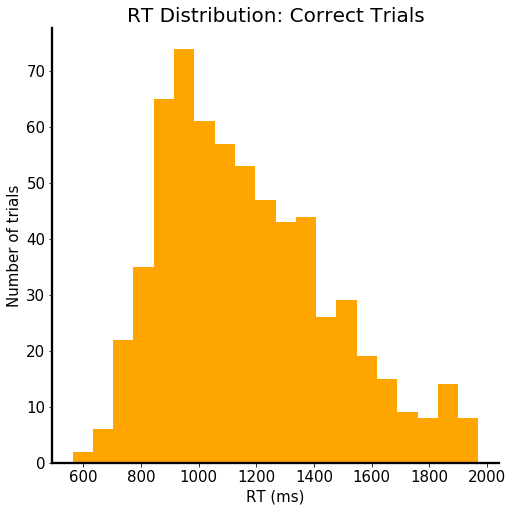

In [383]:

fig, ax = plt.subplots(figsize=[8,8])
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)



for axis in ['bottom','left']:

    ax.spines[axis].set_linewidth(2.3)

plt.hist(np.array(RTs_correctOnly), color='orange', bins=20)
plt.title('RT Distribution: Correct Trials', fontsize=20)
plt.xlabel('RT (ms)', fontsize=15)
plt.ylabel('Number of trials', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Analyze Data by Mis-scaling Rating

In [438]:
data_1 = final_data.loc[final_data['rating'] == 1]
data_2 = final_data.loc[final_data['rating'] == 2]
data_3 = final_data.loc[final_data['rating'] == 3]
data_4 = final_data.loc[final_data['rating'] == 4]




In [446]:
len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])

(111, 79, 41, 151)

In [447]:
len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy'])


(111, 79, 41, 151)

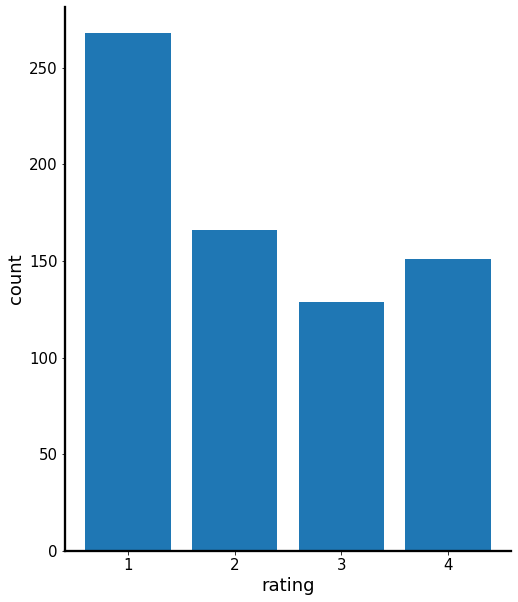

In [386]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)
    
plt.bar(['1', '2', '3', '4'], [268, 166, 129, 151])
plt.show()

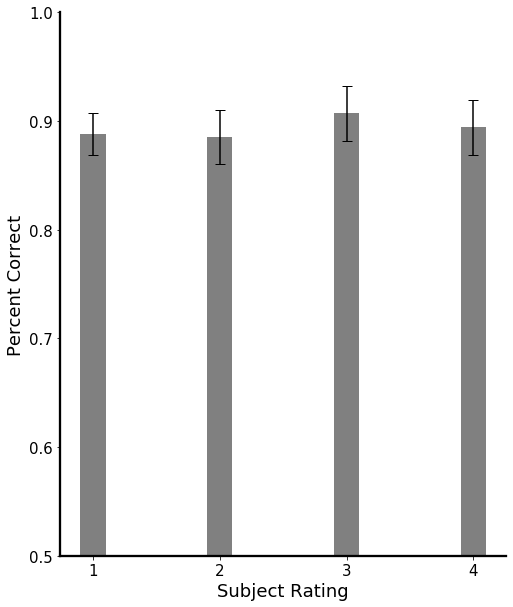

In [387]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

Acc_ =   [np.sum(np.array(data_1['accuracy']))/len(np.array(data_1['accuracy'])), np.sum(np.array(data_2['accuracy']))/len(np.array(data_2['accuracy'])), np.sum(np.array(data_3['accuracy']))/len(np.array(data_3['accuracy'])), np.sum(np.array(data_4['accuracy']))/len(np.array(data_4['accuracy']))]
yerr_ =  [np.std(np.array(data_1['accuracy']))/np.sqrt(len(np.array(data_1['accuracy']))), np.std(np.array(data_2['accuracy']))/np.sqrt(len(np.array(data_2['accuracy']))), np.std(np.array(data_3['accuracy']))/np.sqrt(len(np.array(data_3['accuracy']))), np.std(np.array(data_4['accuracy']))/np.sqrt(len(np.array(data_4['accuracy'])))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, Acc_, width, color='gray', yerr=yerr_, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(0.50, 1)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

In [388]:
data_1_zo = data_1.loc[data_1['scene1ZoomName'] == 'zo']
data_1_zi = data_1.loc[data_1['scene1ZoomName'] == 'zi']

data_2_zo = data_2.loc[data_2['scene1ZoomName'] == 'zo']
data_2_zi = data_2.loc[data_2['scene1ZoomName'] == 'zi']

data_3_zo = data_3.loc[data_3['scene1ZoomName'] == 'zo']
data_3_zi = data_3.loc[data_3['scene1ZoomName'] == 'zi']

data_4_zo = data_4.loc[data_4['scene1ZoomName'] == 'zo']
data_4_zi = data_4.loc[data_4['scene1ZoomName'] == 'zi']


In [389]:
# Accuracy

data_1_zo_acc = np.sum(np.array(data_1_zo['accuracy']))/len(np.array(data_1_zo['accuracy']))
data_1_zi_acc =np.sum(np.array(data_1_zi['accuracy']))/len(np.array(data_1_zi['accuracy']))

data_1_zo_sem = np.std(np.array(data_1_zo['accuracy']))/np.sqrt(len(np.array(data_1_zo['accuracy'])))
data_1_zi_sem = np.std(np.array(data_1_zi['accuracy']))/np.sqrt(len(np.array(data_1_zi['accuracy'])))

print(len(np.array(data_1_zo['accuracy'])))
print(len(np.array(data_1_zi['accuracy'])))


data_2_zo_acc = np.sum(np.array(data_2_zo['accuracy']))/len(np.array(data_2_zo['accuracy']))
data_2_zi_acc =np.sum(np.array(data_2_zi['accuracy']))/len(np.array(data_2_zi['accuracy']))

data_2_zo_sem = np.std(np.array(data_2_zo['accuracy']))/np.sqrt(len(np.array(data_2_zo['accuracy'])))
data_2_zi_sem = np.std(np.array(data_2_zi['accuracy']))/np.sqrt(len(np.array(data_2_zi['accuracy'])))

print(len(np.array(data_2_zo['accuracy'])))
print(len(np.array(data_2_zi['accuracy'])))


data_3_zo_acc = np.sum(np.array(data_3_zo['accuracy']))/len(np.array(data_3_zo['accuracy']))
data_3_zi_acc =np.sum(np.array(data_3_zi['accuracy']))/len(np.array(data_3_zi['accuracy']))

data_3_zo_sem = np.std(np.array(data_3_zo['accuracy']))/np.sqrt(len(np.array(data_3_zo['accuracy'])))
data_3_zi_sem = np.std(np.array(data_3_zi['accuracy']))/np.sqrt(len(np.array(data_3_zi['accuracy'])))

print(len(np.array(data_3_zo['accuracy'])))
print(len(np.array(data_3_zi['accuracy'])))

data_4_zo_acc = np.sum(np.array(data_4_zo['accuracy']))/len(np.array(data_4_zo['accuracy']))
data_4_zi_acc =np.sum(np.array(data_4_zi['accuracy']))/len(np.array(data_4_zi['accuracy']))

data_4_zo_sem = np.std(np.array(data_4_zo['accuracy']))/np.sqrt(len(np.array(data_4_zo['accuracy'])))
data_4_zi_sem = np.std(np.array(data_4_zi['accuracy']))/np.sqrt(len(np.array(data_4_zi['accuracy'])))

print(len(np.array(data_4_zo['accuracy'])))
print(len(np.array(data_4_zi['accuracy'])))


140
128
77
89
70
59
66
85


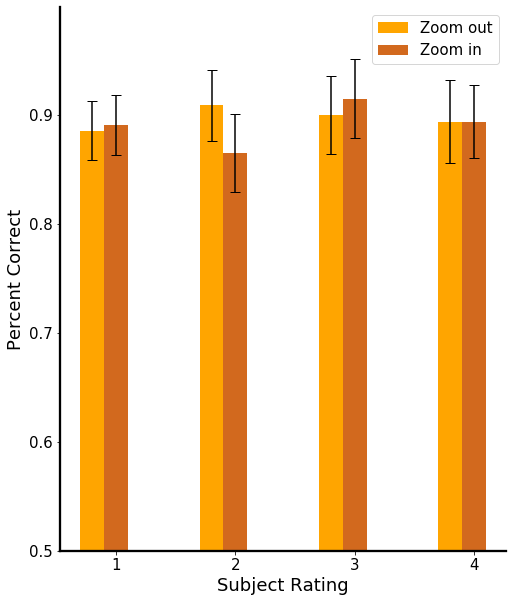

In [390]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

Acc_zo =   [data_1_zo_acc, data_2_zo_acc, data_3_zo_acc, data_4_zo_acc]
yerr_zo =  [data_1_zo_sem, data_2_zo_sem, data_3_zo_sem, data_4_zo_sem]

Acc_zi =   [data_1_zi_acc, data_2_zi_acc, data_3_zi_acc, data_4_zi_acc]
yerr_zi =  [data_1_zi_sem, data_2_zi_sem, data_3_zi_sem, data_4_zi_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_zo, width, color='orange', label='Zoom out', yerr=yerr_zo, capsize=5)
plt.bar(x, Acc_zi, width, color='chocolate', label='Zoom in', yerr=yerr_zi, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(0.50)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [391]:
data_1_objectScene1SemanticCongruency0 = data_1.loc[data_1['objectScene1SemanticCongruency'] == 0]
data_1_objectScene1SemanticCongruency1 = data_1.loc[data_1['objectScene1SemanticCongruency'] == 1]

data_2_objectScene1SemanticCongruency0 = data_2.loc[data_2['objectScene1SemanticCongruency'] == 0]
data_2_objectScene1SemanticCongruency1 = data_2.loc[data_2['objectScene1SemanticCongruency'] == 1]

data_3_objectScene1SemanticCongruency0 = data_3.loc[data_3['objectScene1SemanticCongruency'] == 0]
data_3_objectScene1SemanticCongruency1 = data_3.loc[data_3['objectScene1SemanticCongruency'] == 1]

data_4_objectScene1SemanticCongruency0 = data_4.loc[data_4['objectScene1SemanticCongruency'] == 0]
data_4_objectScene1SemanticCongruency1 = data_4.loc[data_4['objectScene1SemanticCongruency'] == 1]


In [392]:
# Accuracy

data_1_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))
data_1_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))

data_1_objectScene1SemanticCongruency0_sem = np.std(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))
data_1_objectScene1SemanticCongruency1_sem = np.std(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))

data_2_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))
data_2_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))

data_2_objectScene1SemanticCongruency0_sem = np.std(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))
data_2_objectScene1SemanticCongruency1_sem = np.std(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))

data_3_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))
data_3_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))

data_3_objectScene1SemanticCongruency0_sem = np.std(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))
data_3_objectScene1SemanticCongruency1_sem = np.std(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))

data_4_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))
data_4_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))

data_4_objectScene1SemanticCongruency0_sem = np.std(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))
data_4_objectScene1SemanticCongruency1_sem = np.std(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))


272
190
122
134


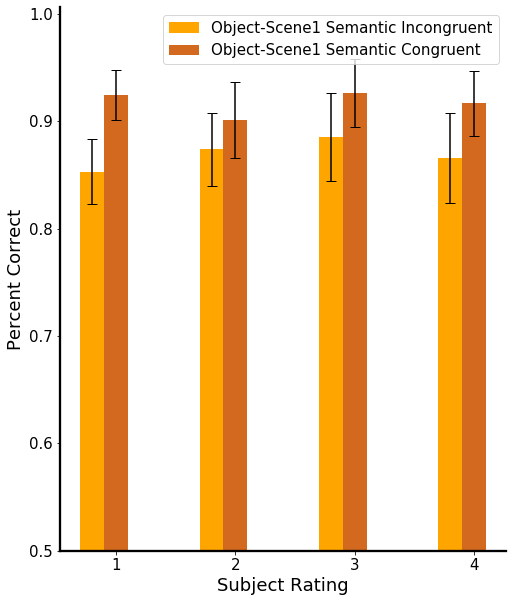

In [393]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

Acc_0 =   [data_1_objectScene1SemanticCongruency0_acc, data_2_objectScene1SemanticCongruency0_acc, data_3_objectScene1SemanticCongruency0_acc, data_4_objectScene1SemanticCongruency0_acc]
yerr_0 =  [data_1_objectScene1SemanticCongruency0_sem, data_2_objectScene1SemanticCongruency0_sem, data_3_objectScene1SemanticCongruency0_sem, data_4_objectScene1SemanticCongruency0_sem]

Acc_1 =   [data_1_objectScene1SemanticCongruency1_acc, data_2_objectScene1SemanticCongruency1_acc, data_3_objectScene1SemanticCongruency1_acc, data_4_objectScene1SemanticCongruency1_acc]
yerr_1 =  [data_1_objectScene1SemanticCongruency1_sem, data_2_objectScene1SemanticCongruency1_sem, data_3_objectScene1SemanticCongruency1_sem, data_4_objectScene1SemanticCongruency1_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_0, width, color='orange', label='Object-Scene1 Semantic Incongruent', yerr=yerr_0, capsize=5)
plt.bar(x, Acc_1, width, color='chocolate', label='Object-Scene1 Semantic Congruent', yerr=yerr_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(0.50)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [448]:
data_1_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 1]
data_2_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 2]
data_3_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 3]
data_4_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 4]

data_1_zo_CO = data_1_CO.loc[data_1_CO['scene1ZoomName'] == 'zo']
data_1_zi_CO = data_1_CO.loc[data_1_CO['scene1ZoomName'] == 'zi']

data_2_zo_CO = data_2_CO.loc[data_2_CO['scene1ZoomName'] == 'zo']
data_2_zi_CO = data_2_CO.loc[data_2_CO['scene1ZoomName'] == 'zi']

data_3_zo_CO = data_3_CO.loc[data_3_CO['scene1ZoomName'] == 'zo']
data_3_zi_CO = data_3_CO.loc[data_3_CO['scene1ZoomName'] == 'zi']

data_4_zo_CO = data_4_CO.loc[data_4_CO['scene1ZoomName'] == 'zo']
data_4_zi_CO = data_4_CO.loc[data_4_CO['scene1ZoomName'] == 'zi']





In [449]:
# RT 
data_1_zo_RT = np.mean(np.array(data_1_zo_CO['RT']))
data_1_zi_RT = np.mean(np.array(data_1_zi_CO['RT']))

data_1_zo_RT_sem = sem(np.array(data_1_zo_CO['RT']))
data_1_zi_RT_sem = sem(np.array(data_1_zi_CO['RT']))


data_2_zo_RT = np.mean(np.array(data_2_zo_CO['RT']))
data_2_zi_RT = np.mean(np.array(data_2_zi_CO['RT']))

data_2_zo_RT_sem = sem(np.array(data_2_zo_CO['RT']))
data_2_zi_RT_sem = sem(np.array(data_2_zi_CO['RT']))


data_3_zo_RT = np.mean(np.array(data_3_zo_CO['RT']))
data_3_zi_RT = np.mean(np.array(data_3_zi_CO['RT']))

data_3_zo_RT_sem = sem(np.array(data_3_zo_CO['RT']))
data_3_zi_RT_sem =sem(np.array(data_3_zi_CO['RT']))


data_4_zo_RT = np.mean(np.array(data_4_zo_CO['RT']))
data_4_zi_RT = np.mean(np.array(data_4_zi_CO['RT']))

data_4_zo_RT_sem = sem(np.array(data_4_zo_CO['RT']))
data_4_zi_RT_sem = sem(np.array(data_4_zi_CO['RT']))



In [450]:
len(data_1_CO['accuracy']), len(data_2_CO['accuracy']), len(data_3_CO['accuracy']), len(data_4_CO['accuracy'])

(238, 147, 117, 135)

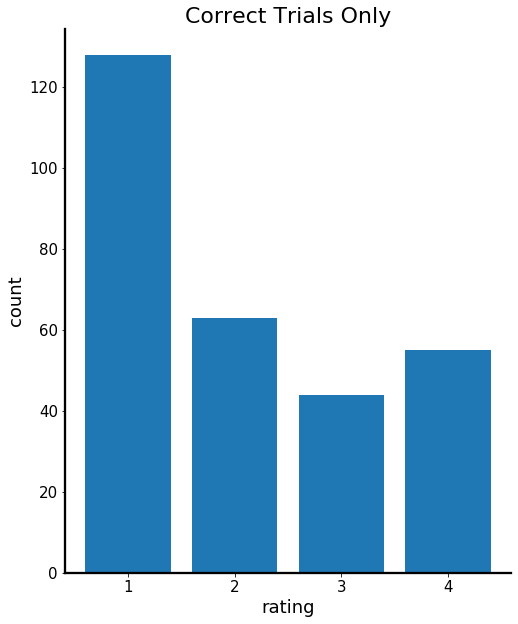

In [451]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)

plt.title('Correct Trials Only', fontsize=22)
    
plt.bar(['1', '2', '3', '4'], [128, 63, 44, 55])

plt.show()

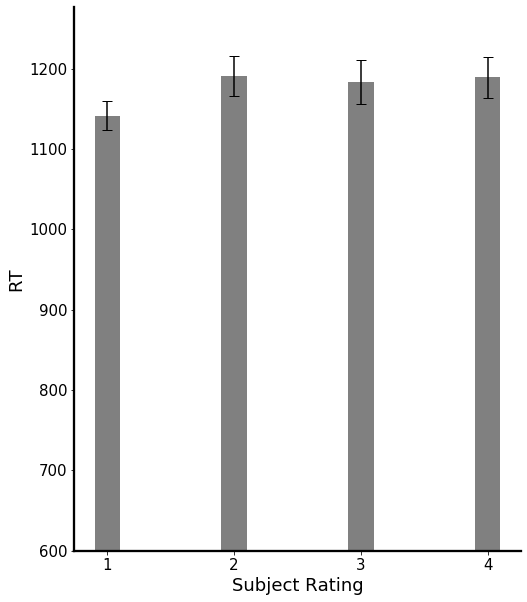

In [452]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_ = [np.mean(np.array(data_1_CO['RT'])), np.mean(np.array(data_2_CO['RT'])), np.mean(np.array(data_3_CO['RT'])), np.mean(np.array(data_4_CO['RT']))]
yerr_RT = [sem(np.array(data_1_CO['RT'])), sem(np.array(data_2_CO['RT'])), sem(np.array(data_3_CO['RT'])), sem(np.array(data_4_CO['RT']))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, RT_, width, color='gray', yerr=yerr_RT, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(600)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

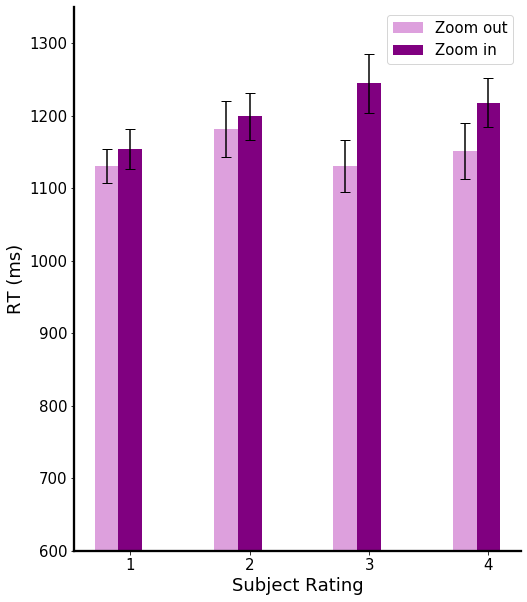

In [453]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_zo =   [data_1_zo_RT, data_2_zo_RT, data_3_zo_RT, data_4_zo_RT]
yerr_RT_zo =  [data_1_zo_RT_sem, data_2_zo_RT_sem, data_3_zo_RT_sem, data_4_zo_RT_sem]

RT_zi =   [data_1_zi_RT, data_2_zi_RT, data_3_zi_RT, data_4_zi_RT]
yerr_RT_zi =  [data_1_zi_RT_sem, data_2_zi_RT_sem, data_3_zi_RT_sem, data_4_zi_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_zo, width, color='plum', label='Zoom out', yerr=yerr_RT_zo, capsize=5)
plt.bar(x, RT_zi, width, color='purple', label='Zoom in', yerr=yerr_RT_zi, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(600)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT (ms)", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [454]:
data_1_objectScene1SemanticCongruency0_CO = data_1_CO.loc[data_1_CO['objectScene1SemanticCongruency'] == 0]
data_1_objectScene1SemanticCongruency1_CO = data_1_CO.loc[data_1_CO['objectScene1SemanticCongruency'] == 1]

data_2_objectScene1SemanticCongruency0_CO = data_2_CO.loc[data_2_CO['objectScene1SemanticCongruency'] == 0]
data_2_objectScene1SemanticCongruency1_CO = data_2_CO.loc[data_2_CO['objectScene1SemanticCongruency'] == 1]

data_3_objectScene1SemanticCongruency0_CO = data_3_CO.loc[data_3_CO['objectScene1SemanticCongruency'] == 0]
data_3_objectScene1SemanticCongruency1_CO = data_3_CO.loc[data_3_CO['objectScene1SemanticCongruency'] == 1]

data_4_objectScene1SemanticCongruency0_CO = data_4_CO.loc[data_4_CO['objectScene1SemanticCongruency'] == 0]
data_4_objectScene1SemanticCongruency1_CO = data_4_CO.loc[data_4_CO['objectScene1SemanticCongruency'] == 1]


In [455]:
data_1_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))

data_1_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))


data_2_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))

data_2_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))


data_3_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))

data_3_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT_sem =sem(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))


data_4_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))

data_4_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))




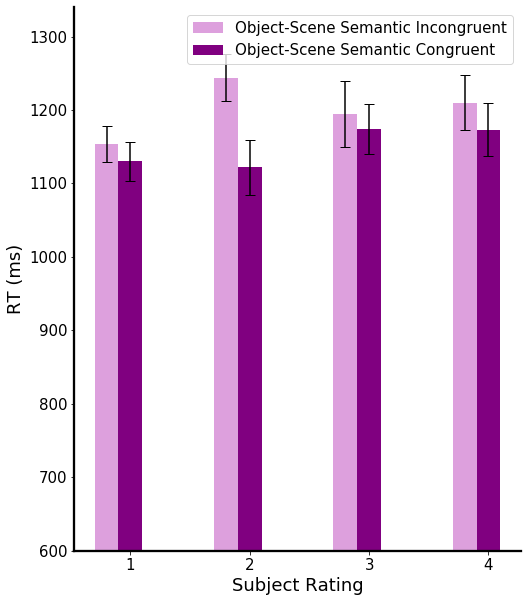

In [456]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(4)

RT_0 =   [data_1_objectScene1SemanticCongruency0_CO_RT, data_2_objectScene1SemanticCongruency0_CO_RT, data_3_objectScene1SemanticCongruency0_CO_RT, data_4_objectScene1SemanticCongruency0_CO_RT]
yerr_RT_0 =  [data_1_objectScene1SemanticCongruency0_CO_RT_sem, data_2_objectScene1SemanticCongruency0_CO_RT_sem, data_3_objectScene1SemanticCongruency0_CO_RT_sem, data_4_objectScene1SemanticCongruency0_CO_RT_sem]

RT_1 =   [data_1_objectScene1SemanticCongruency1_CO_RT, data_2_objectScene1SemanticCongruency1_CO_RT, data_3_objectScene1SemanticCongruency1_CO_RT, data_4_objectScene1SemanticCongruency1_CO_RT]
yerr_RT_1 =  [data_1_objectScene1SemanticCongruency1_CO_RT_sem, data_2_objectScene1SemanticCongruency1_CO_RT_sem, data_3_objectScene1SemanticCongruency1_CO_RT_sem, data_4_objectScene1SemanticCongruency1_CO_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_0, width, color='plum', label='Object-Scene Semantic Incongruent', yerr=yerr_RT_0, capsize=5)
plt.bar(x, RT_1, width, color='purple', label='Object-Scene Semantic Congruent', yerr=yerr_RT_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4], fontsize='15')
plt.ylim(600)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT (ms)", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

## Distribution of Ratings in Mis-scaled and Scaled